# 0.0. IMPORTS

In [1]:
import math
import pandas as pd
import inflection
import numpy as np
from numpy import int64
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import gridspec

## 0.1. Helper Funcions

## 0.2 Loading Data

In [2]:
# low memory = False significa que vai carregar todo o arquivo em memória. Caso tenho restrição com memória,
# low_memory=True carrega chunks do arquivo na memória.
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# Realiza o merge dos dois datasets df_sales_raw e df_store_raw. O atributo on='Store' define que a coluna Store é 
# a coluna que aparece em ambos os datasets e será utilizado como chave para fazer o merge.
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [3]:
# O comando sample exibe uma linha aleatória do dataset.
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
852253,64,2,2013-05-28,9709,704,1,1,0,0,d,c,22560.0,NaN,NaN,1,14.0,2013.0,"Jan,Apr,Jul,Oct"


# 1.0 DESCRIÇÃO DOS DADOS

In [4]:
# É recomendado realizar uma cópia do dataset em cada um das seçoes do Jupyter Notebook, pois se o notebook tem muitas seções
# e em um exemplo onde estamos na última seção e reescrevemos os dados originais e ocorre um erro. Neste caso para recuperarmos
# os dados originais, temos que voltar na primeira seção do Jupyter Notebook e executar todas as linhas até o final.
# Para evitar este problema é recomendado criar uma cópia do dataset em cada seção.
df1 = df_raw.copy()

## 1.1 Rename Columns

In [5]:
# Exibe as colunas do dataset df1, no formato original CamelCase.
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [6]:
# Cria uma lista com os nomes originais das colunas.
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType',
            'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
            'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

# Altera o estilo dos nomes das colunas de CamelCase para SnakeCase utilizando a função abaixo.
snakecase = lambda x: inflection.underscore(x)

# A função map executa a função snakecase em todas as palavras da lista cols_old. A saída desta função é convertida em uma 
# lista e armazenada na lista cols_new.
cols_new = list(map(snakecase, cols_old))

# Renomeia o nome das colunas no dataset df1.
df1.columns = cols_new

In [7]:
# Exibe o nome das colunas do dataset df1 no formato alterado snakecase.
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [8]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of columns: 18


## 1.3 Data Types

In [9]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [10]:
# Altera o tipo dos valore da coluna date de object (string) para data.
df1['date'] = pd.to_datetime(df1['date'])

In [11]:
df1.dtypes 

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [12]:
# O método isna exibe todas as linhas que possuem valores vazios. O método sum exibe a quantidade de linhas que possuem 
# valores vazios / NA(não aplicável).
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

### 1.5.1. competition_distance

In [13]:
# competition_distance
# No site do Kagle temos a seguinte definição para esta coluna: distance in meter to the nearest competitor store.
# Iremos verificar no dataset qual é a distância em metros do competidor mais distante.
print(df1['competition_distance'].max())

75860.0


In [14]:
# O valor em metros do competidor mais distante é 75860.
# Então iremos assumir para os valores NA, um valor muito mais distante do que o competidor mais distante no nosso dataset.
# Neste caso, iremos considerar um valor de 200000 para os valores NA/vazio.

# O método math.isnan retorna se um valor em uma coluna específica é NA/vazio.
# No exemplo abaixo, temos uma condição onde se o valor da coluna competition_distance for vazio, substitui pelo valor 200000.0.
# 200000.0 if math.isnan (df1['competition_distance']) else df1['competition_distance']

# Para aplicarmos esta condição em todo o dataset, temos que utilizar as funções apply e lambda, conforme exemplo abaixo:
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

In [15]:
# Verificamos agora que o maximo valor da columa competition_distance é 200000.0 e não existe mais valores vazios:
print(df1['competition_distance'].max())
df1.isna().sum()

200000.0


store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5.2. competition_open_since_month

In [16]:
# competition_open_since_month
# No site do Kagle temos a seguinte definição para esta coluna: gives the approximate year and month of the time the nearest
# competitor was opened.
# O valor pode estar vazio porque não possui competidor, ou porque não sabemos a data de abertura do concorrente (pode ter
# sido aberta antes da inauguração da nossa loja, ou abriu depois mas alguém esqueceu de anotar.)
# Iremos então assumir como premissa, o valor do mês da coluna date. Iremos fazer isto pensando na etapa de feature engineering.
# Por exemplo, quanto tempo faz que um evento ocorreu? Iremos manter este valor na coluna, pois um competidor influencia no 
# volume de vendas. Quando um competidor abre recentemente, o volume de vendas na nossa loja cai. Com o tempo, as vendasB
# no nossa loja aumentam, porém não vão retornar ao patamar antes da inauguração do competidor.
# Assumir o valor do mês do campo date pode não ter lógica, pois temos a influência do campo competition_distance.
# Não sabemos se esta premissa vai funcionar, por isso, utilizamos o CRISP. Na primeira iteração do CRISP, iremos utilizar
# esta premissa. Se o algoritmos não performar bem, no próximo ciclo do CRISP, talvez podemos alterar esta premisa para
# esta coluna.

# O método math.isnan retorna se um valor em uma coluna específica é NA/vazio.
# No exemplo abaixo, temos uma condição onde se o valor da coluna competition_open_since_month for vazio, substitui pelo valor
# da coluna data.
# df1['date'].month if math.isnan (df1['competition_open_since_month']) else df1['competition_open_since_month']

# Para aplicarmos esta condição em todo o dataset, temos que utilizar as funções apply e lambda, conforme exemplo abaixo:

In [17]:
# Quando utilizamos mais de uma coluna, temos que especificar para a função apply que iremos aplicar os valores ao longo das
# colunas, utilizando o atributo axis=1.
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

### 1.5.3. competition_open_since_year

In [18]:
# competition_open_since_year
# No site do Kagle temos a seguinte definição para esta coluna: gives the approximate year and month of the time the nearest
# competitor was opened.
# O valor pode estar vazio porque não possui competidor, ou porque não sabemos a data de abertura do concorrente (pode ter
# sido aberta antes da inauguração da nossa loja, ou abriu depois mas alguém esqueceu de anotar.)
# Iremos então assumir como premissa, o valor do ano da coluna date. Iremos fazer isto pensando na etapa de feature engineering.
# Por exemplo, quanto tempo faz que um evento ocorreu? Iremos manter este valor na coluna, pois um competidor influencia no 
# volume de vendas. Quando um competidor abre recentemente, o volume de vendas na nossa loja cai. Com o tempo, as vendasB
# no nossa loja aumentam, porém não vão retornar ao patamar antes da inauguração do competidor.
# Assumir o valor do ano do campo date pode não ter lógica, pois temos a influência do campo competition_distance.
# Não sabemos se esta premissa vai funcionar, por isso, utilizamos o CRISP. Na primeira iteração do CRISP, iremos utilizar
# esta premissa. Se o algoritmos não performar bem, no próximo ciclo do CRISP, talvez podemos alterar esta premisa para
# esta coluna.

# O método math.isnan retorna se um valor em uma coluna específica é NA/vazio.
# No exemplo abaixo, temos uma condição onde se o valor da coluna competition_open_since_year for vazio, substitui pelo valor
# da coluna data.
# df1['date'].year if math.isnan (df1['competition_open_since_year']) else df1['competition_open_since_year']

# Para aplicarmos esta condição em todo o dataset, temos que utilizar as funções apply e lambda, conforme exemplo abaixo:

In [19]:
# Quando utilizamos mais de uma coluna, temos que especificar para a função apply que iremos aplicar os valores ao longo das
# colunas, utilizando o atributo axis=1.
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

### 1.5.4. promo2_since_week

In [20]:
# promo2_since_week.
# # No site do Kagle temos a seguinte definição para esta coluna: describes the year and calendar week when the store started
# participating in Promo2.
# Iremos substituir os valores faltantes pelo valor de week da coluna date.

# O método math.isnan retorna se um valor em uma coluna específica é NA/vazio.
# No exemplo abaixo, temos uma condição onde se o valor da coluna promo2_since_week for vazio, substitui pelo valor da coluna
# data.
# df1['date'].week if math.isnan (df1['promo2_since_week']) else df1['promo2_since_week']

# Para aplicarmos esta condição em todo o dataset, temos que utilizar as funções apply e lambda, conforme exemplo abaixo:

In [21]:
# Quando utilizamos mais de uma coluna, temos que especificar para a função apply que iremos aplicar os valores ao longo das
# colunas, utilizando o atributo axis=1.
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

### 1.5.5. promo2_since_year

In [22]:
# promo2_since_year.
# # No site do Kagle temos a seguinte definição para esta coluna: describes the year and calendar week when the store started
# participating in Promo2.
# Iremos substituir os valores faltantes pelo valor de year da coluna date.

# O método math.isnan retorna se um valor em uma coluna específica é NA/vazio.
# No exemplo abaixo, temos uma condição onde se o valor da coluna promo2_since_year for vazio, substitui pelo valor da coluna
# data.
# df1['date'].year if math.isnan (df1['promo2_since_year']) else df1['promo2_since_year']

# Para aplicarmos esta condição em todo o dataset, temos que utilizar as funções apply e lambda, conforme exemplo abaixo:

In [23]:
# Quando utilizamos mais de uma coluna, temos que especificar para a função apply que iremos aplicar os valores ao longo das
# colunas, utilizando o atributo axis=1.
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

### 1.5.6. promo_interval

In [24]:
# promo_interval.
# # No site do Kagle temos a seguinte definição para esta coluna: describes the consecutive intervals Promo2 is started,
# naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August,
# November of any given year for that store.

# Será criada uma coluna is_promo atribuindo o valor 0 quando a loja não participou da promoção. Caso contrário será atribuído
# o valor 1.

In [25]:
#Cria uma dicionário com os valores e nomes dos meses.
month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

In [26]:
# Se o valor da coluna promo_interval for NA/vazio, atribui o valor 0.
df1['promo_interval'].fillna(0, inplace=True) # inplace=True não exibe o resultado na tela.

In [27]:
# O comando abaixo cria uma coluna month_map, onde iremos abribuir o valor do mês do dicionário month_map de acordo com o 
# valor do mês que se encontra na coluna date.
df1['month_map'] = df1['date'].dt.month.map(month_map)

In [28]:
# Podemos realizar a mesma operação utilizando o comando abaixo:
# df1['month_map'] = df1['date'].dt.month.apply(lambda x: calendar.month_abbr[x])
# Porém, o tempo de execução é bem maior do que o comando: df1['month_map'] = df1['date'].dt.month.map(month_map).

In [29]:
# O comando abaixo exibe 5 amostras de linhas, onde cada amostra é exibida em uma coluna.
df1.sample(5).T

,324054,682318,505832,511190,684588
store,863,724,408,191,764
day_of_week,1,1,5,7,6
date,2014-09-29 00:00:00,2013-10-28 00:00:00,2014-04-04 00:00:00,2014-03-30 00:00:00,2013-10-26 00:00:00
sales,10006,5735,4721,0,1622
customers,1095,646,474,0,183
open,1,1,1,0,1
promo,1,0,1,0,0
state_holiday,0,0,0,0,0
school_holiday,0,1,0,0,0
store_type,a,d,c,a,a


In [30]:
# É criada uma coluna chamada is_promo.
# É criada a seguinte condição: se o valor da coluna promo_interval for igual à 0, será atribuído o valor 0 na coluna is_promo,
# significando que ela não está participando da promoção.
# Se o valor da coluna promo_interval for diferente de zero, iremos atribuir o valor 1 na coluna is_promo, se algum dos meses
# contidos no valor da coluna promo_interval for igual ao valor do mês na coluna month_map. Caso contrário, será atribuído
# o valor 0 na coluna is_promo.
# É utilizada a função split para criar uma lista com os valores contidos na coluna promo_interval, considerando que os valores
# são separados por vírgula.
# 0 if df1['promo_interval'] == 0 else 1 if df1['month_map'] in df1['promo_interval'].split(',') else 0

# Para aplicarmos esta condição em todo o dataset, temos que utilizar as funções apply e lambda, conforme exemplo abaixo:
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [31]:
# O comando abaixo verifica uma determinada condição. Fiz este comando porque havia escrito 'Sep' em vez de 'Sept' na list
# month_map o que estava causando uma diferença nos valores do descriptive statistical.
# O comando abaixo cria um dataset df_teste que contem o valor Sept na coluna month_map e que contém a string 'Sept' no valor
# da coluna promo_interval.
df_teste = df1[(df1['month_map'] == 'Sept') & (df1['promo_interval'].str.contains('Sept'))]
df_teste.sample(5).T

,722375,328256,729849,724480,721634
store,641,302,310,516,1015
day_of_week,7,3,7,5,1
date,2013-09-22 00:00:00,2014-09-24 00:00:00,2013-09-15 00:00:00,2013-09-20 00:00:00,2013-09-23 00:00:00
sales,0,2697,2960,3354,6558
customers,0,239,255,539,520
open,0,1,1,1,1
promo,0,0,0,0,1
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,d,a,a,d


In [32]:
# O comando abaixo exibe 5 amostras de linhas, onde cada amostra é exibida em uma coluna.
df1.sample(5).T

,23974,1003201,491311,296327,862530
store,560,487,382,128,306
day_of_week,5,7,4,2,7
date,2015-07-10 00:00:00,2013-01-13 00:00:00,2014-04-17 00:00:00,2014-10-28 00:00:00,2013-05-19 00:00:00
sales,13351,0,11566,6857,0
customers,1634,0,962,538,0
open,1,0,1,1,0
promo,0,0,1,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,1,1,0
store_type,c,d,c,d,a


In [33]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Type

In [34]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [35]:
# Altera os valores das colunas abaixo de float para int64.
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int64)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int64)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int64)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int64)

In [36]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [37]:
df1.sample(5).T

,639685,474924,894352,816336,104811
store,461,720,908,942,2
day_of_week,4,5,7,7,2
date,2013-12-05 00:00:00,2014-05-02 00:00:00,2013-04-21 00:00:00,2013-06-30 00:00:00,2015-04-28 00:00:00
sales,5526,9916,0,0,6861
customers,521,893,0,0,678
open,1,1,0,0,1
promo,1,1,0,0,1
state_holiday,0,0,0,0,0
school_holiday,0,1,0,0,0
store_type,d,a,a,d,a


## 1.7 Descriptive Statistical

In [38]:
# Primeiro devemos separar os dados númericos dos dados categóricos em diferentes dataset.
# No exemplo abaixo, foi criado um dataset num_attributes para armazenar os valores numéricos e um dataset chamado
# cat_attributes para armazenar os valores categóricos (exclui números inteiros, float e data).
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [39]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T  # Calcula a média.
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T  # Calcula a mediana.

# Dispersion - std, min, max, range(max-min), skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
# Concate os dataframes em um único dataframe chamado m.
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6 ]).T.reset_index()

# Renomeia as colunas
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

# O VALOR DE IS_PROMO ESTÁ DIFERENTE DOS VALORES MOSTRADOS NO TREINAMENTO.

In [40]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


In [41]:
# skew: é uma medidade de quanto assimetrico está uma distribuição.
# https://medium.com/@atanudan/kurtosis-skew-function-in-pandas-aa63d72e20de
# Em uma distribuição normal, a média divide a curva simetricamente em duas partes iguais na mediana e o valor da assimetria
# é zero.
# Quando uma distribuição é assimétrica, a cauda da distribuição é inclinada para um lado para a direita ou para a esquerda.
# Quando o valor da assimetria é negativo, a cauda da distribuição é mais longa para o lado esquerdo da curva.
# Quando o valor da assimetria é positivo, a cauda da distribuição é mais longa para o lado direito da curva.

# Se a assimetria estiver entre -0,5 e 0,5, os dados são bastante simétricos.
# Se a assimetria estiver entre -1 e - 0,5 ou entre 0,5 e 1, os dados estão moderadamente inclinados.
# Se a assimetria for menor que -1 ou maior que 1, os dados estão altamente inclinados.

# O exemplo abaixo exibe a distribuição da coluna competition_distance, onde podemos observar a cauda da distribuição para
# o lado direito, correspondendo ao valor do skew positivo próximo de 10.

C:\Users\adriano.clemente\Anaconda3\envs\DataScienceEmProducao\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

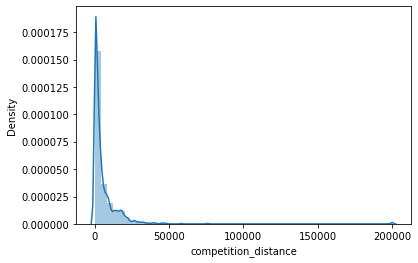

In [42]:
# A função distplot do seaborn exibe a distribuição dos dados.
sns.distplot(df1['competition_distance'])

In [43]:
# kurtosis: é uma das duas medidas que quantificam a forma de uma distribuição.
# kurtosis determina o volume de outliers, descrevendo o pico da distribuição.

# Se a distribuição for alta e fina, é chamada de distribuição leptocúrtica (kurtosis > 3). Os valores em uma distribuição
# leptocúrtica estão próximos da média ou nos extremos.
# Uma distribuição plana onde os valores são moderadamente espalhados (isto é, ao contrário da leptocúrtica) é chamada de 
# distribuição platicúrtica (kurtosis <3).
# Uma distribuição cuja forma está entre uma distribuição leptocúrtica e uma distribuição platicúrtica é chamada de
# distribuição mesocúrtica (kurtosis = 3). Uma distribuição mesocúrtica parece mais próxima de uma distribuição normal.

# É a nitidez do pico de uma curva de distribuição de frequência. É a medida dos outliers presentes na distribuição.
# Uma alta kurtosis em um conjunto de dados é um indicador de que os dados possuem muitos outliers.
# Uma baixa kurtosis em um conjunto de dados é um indicador de que os dados possuem poucos outliers.

C:\Users\adriano.clemente\Anaconda3\envs\DataScienceEmProducao\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='customers', ylabel='Density'>

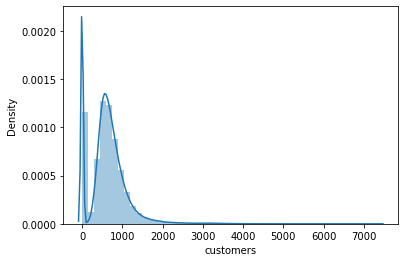

In [44]:
sns.distplot(df1['customers'])

C:\Users\adriano.clemente\Anaconda3\envs\DataScienceEmProducao\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

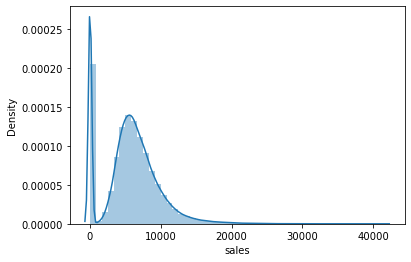

In [45]:
sns.distplot(df1['sales'])

### 1.7.2 Categorical Attributes

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

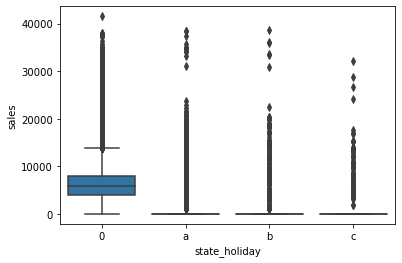

In [46]:
# Iremos utilizar boxplot para exibir a distribuiçãdo dos dados categóricos.
# O exemplo abaixo exibe a distribuição das vendas de acordo com os feriados.
sns.boxplot(x='state_holiday', y='sales', data=df1)

<AxesSubplot:xlabel='assortment', ylabel='sales'>

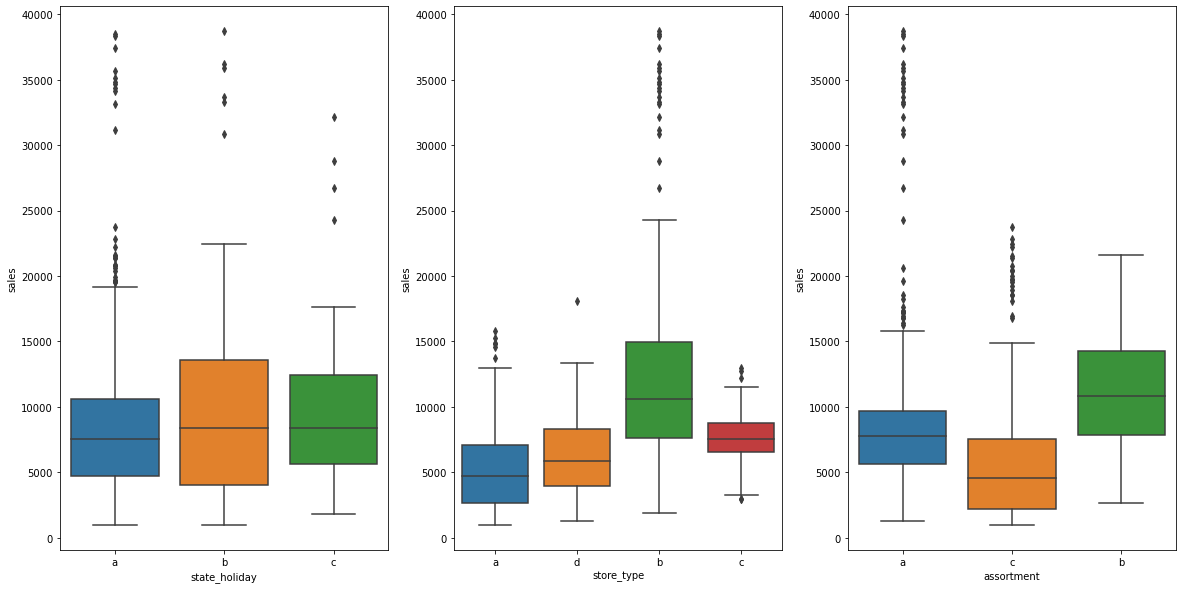

In [47]:
# O exemplo acima exibe uma distribuição muito dispersa dos dados, pois a dimensão das variáveis está muito diferente.
# Isto é muito provavel de ocorrer, pois temos dias que são feriados, onde a loja está fechada e consequentemente a quantidade
# de vendas é zero.
# Neste caso, a coluna 0 que representa dias sem feriados possui um volume de vendas bem maior que as outras três colunas
# a, b e c que são feriados: a = public holiday, b = Easter holiday, c = Christmas.
# Desta maneira, iremos criar dois boxplots separados, um para os dias normais e outro para os feriados.
# O exemplo abaixo considera os dias que são feriados, onde a loja estava aberta, isto é, com vendas diferentes de zero.
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.figure(figsize=(20,10))

plt.subplot (1,3,1)  # Uma linha, três colunas e primeira posição.
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot (1,3,2)  # Uma linha, três colunas e segunda posição.
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot (1,3,3)  # Uma linha, três colunas e terceira posição.
sns.boxplot(x='assortment', y='sales', data=aux1)

<AxesSubplot:xlabel='assortment', ylabel='sales'>

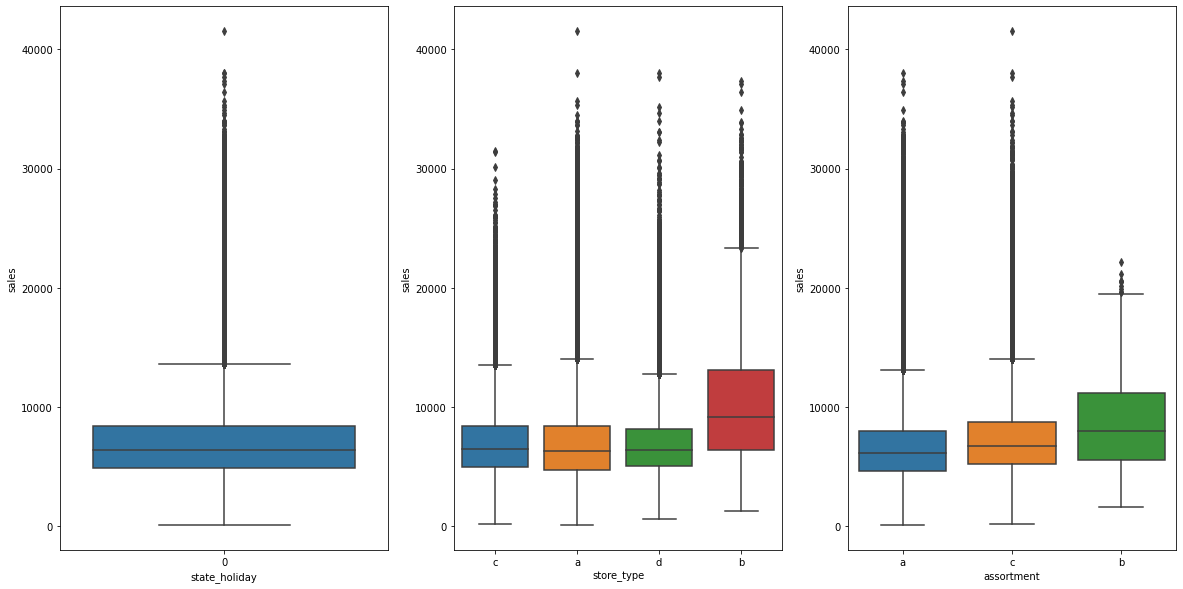

In [49]:
# O exemplo acima exibe uma distribuição muito dispersa dos dados, pois a dimensão das variáveis está muito diferente.
# Isto é muito provavel de ocorrer, pois temos dias que são feriados, onde a loja está fechada e consequentemente a quantidade
# de vendas é zero.
# Neste caso, a coluna 0 que representa dias sem feriados possui um volume de vendas bem maior que as outras três colunas
# a, b e c que são feriados: a = public holiday, b = Easter holiday, c = Christmas.
# Desta maneira, iremos criar dois boxplots separados, um para os dias normais e outro para os feriados.
# O exemplo abaixo considera os dias que não são feriados, onde a loja estava aberta, isto é, com vendas diferentes de zero.
aux2 = df1[(df1['state_holiday'] == '0') & (df1['sales'] > 0)]

plt.figure(figsize=(20,10))

plt.subplot (1,3,1)  # Uma linha, três colunas e primeira posição.
sns.boxplot(x='state_holiday', y='sales', data=aux2)

plt.subplot (1,3,2)  # Uma linha, três colunas e segunda posição.
sns.boxplot(x='store_type', y='sales', data=aux2)

plt.subplot (1,3,3)  # Uma linha, três colunas e terceira posição.
sns.boxplot(x='assortment', y='sales', data=aux2)

In [48]:
# A linha do meio representa a mediana (quartil 50).
# A linha inferior da caixa é o auartil 25.
# A linha superior da caixa é o quartil 75.
# A barra supeior é o valor máximo.
# A barra inferior é o valor mínimo.
# Os pontos acima e abaixo das barras são os outliers. Os dados são considerados outliers quando possuem três vezes o valor do
# desvio padrão.